81610 - Machine Learning project

# Introduction 
This project contains a sentiment analysis on a IMDB reviews dataset. The dataset contains 50,000 highly polar movie reviews labeled by sentiment, in which there is an even number of positive and negative reviews. Half of the dataset is used for training+validation and the other half is used for testing. Three different deep learning networks are constructed; a MLP, CNN and LSTM. This is done by using Keras Sequential API. At the end the different models are tested on a couple of tweets and then the performances are discussed. 

# Libraries and installments

In [14]:
# General libaries
import numpy as np
from random import randrange

# For models 
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Activation, Dropout
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# For data visualisation
import matplotlib
import matplotlib.pyplot as plt

In [15]:
!pip install h5py


# Dataset
The models will use all the words in the vocabulary.


**Importing the dataset from Keras**

In [16]:
# Import dataset
from keras.datasets import imdb
word_indices = imdb.get_word_index()
vocabulary = len(word_indices)
print("There are",vocabulary, "unique words")

There are 88584 unique words


In [17]:
# Loading the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocabulary)

# Merging the training and test sets
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

**Exploring the dataset**

In [18]:
# Properties of the dataset
print("Size of dataset:", len(x))
print("Size of training data:", len(x_train))
print("Size of test data:", len(x_test))
print("Classification of data:", np.unique(y))

Size of dataset: 50000
Size of training data: 25000
Size of test data: 25000
Classification of data: [0 1]


In [19]:
# The length of the longest review  
longest_review = max(len(review) for review in x)
print("The longest review:", longest_review)

# Average size of a review
sizes = [len(x_i) for x_i in x]
print("Average review length:", np.mean(sizes))

# Median length of a review
print("Median review legth:", np.median(sizes))

The longest review: 2494
Average review length: 234.75892
Median review legth: 176.0


In [20]:
# Format of a review
print(x[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [21]:
# Decoding the first review
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
first_review = " ".join( [reverse_index.get(i - 3, "?") for i in x[0]] )
print(first_review) 
print("This review is classified as:", (y[0]))

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

In [22]:
# Decoding a randow review
random_no = randrange(len(x))
random_review = " ".join( [reverse_index.get(i - 3, "?") for i in x[random_no]] )
print(random_review)
print("This review is classified as:", (y[random_no]))

? after 30 seconds you already realize that there was no real budget for this cheap knock off the story is taken from great movies like texas chainsaw massacre and hills have eyes i like those kind of movies even if they're duplicated well wrong turn timber falls carver br br but side sho is hard to watch the actors are really bad the dialogue is cheesy and the music is stupid and totally misplaced you do not care at all what happens to the characters the so called bad guys are also not interesting at all and rather stereotypical so how about the blood and gore well there is some although it is rather cheap and the action is executed very poorly 2 points just for the gore and blood but do understand that this is hardly worth a look even for the gore hounds
This review is classified as: 0


# Preparing the data
In order to feed the data into a neural network it is necessary to preprocess it. This is done through word embedding in which words are encoded as vectors in a high dimensional space. Keras' Embedding Layer is used for this and it is inputed to all the models as the first layer. 

In [23]:
# All reviews need to have the same length
review_length = 500

# Transforming to usable arrays
x_train = sequence.pad_sequences(x_train, maxlen=review_length)
x_test = sequence.pad_sequences(x_test, maxlen=review_length)

print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)

Shape of training data: (25000, 500)
Shape of test data: (25000, 500)


In [24]:
# Create embedded layer for use in models
embedded_layer = Embedding(input_dim=vocabulary, 
                           output_dim=32, 
                           input_length=review_length)

print("Embedded layer is created")

Embedded layer is created


# Multi-Layered Perceptron (MLP)

**Constructing the model**

The first model is a multi-layered perceptron with one hidden layer of 250 hidden units. Stochastic gradient descent is used as the optimizer with binary crossentropy as the loss function.

In [25]:
# Builds a sequential model by adding one layer at a time
model1 = Sequential()
model1.add(embedded_layer)
model1.add(Flatten())
model1.add(Dense(units=250,
                 use_bias = True,
                 activation="relu"))
model1.add(Dropout(0.5)) 
model1.add(Dense(1,  
                 activation="sigmoid"))
model1.compile(loss='binary_crossentropy', 
               optimizer='sgd', 
               metrics=['accuracy']) 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           2834688   
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 250)               4000250   
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                                 
Total params: 6,835,189
Trainable params: 6,835,189
Non-trainable params: 0
_________________________________________________________________


**Training the model**


In [29]:
# To prevent overfitting
es = EarlyStopping(monitor='val_accuracy', 
                   patience=3)

# To save the best model observed during training
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# To tune the learning rate
rlronp = ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1, 
                          patience=3)

# Final model
history1 = model1.fit(x_train, 
                      y_train, 
                      validation_split=0.1, 
                      batch_size=64,
                      epochs=20, 
                      callbacks=[es, rlronp, mc])


Epoch 1/20
352/352 [==============================] - 20s 56ms/step - loss: 0.6904 - accuracy: 0.5344 - val_loss: 0.6912 - val_accuracy: 0.5228 - lr: 0.0100
Epoch 2/20
352/352 [==============================] - 20s 56ms/step - loss: 0.6895 - accuracy: 0.5406 - val_loss: 0.6913 - val_accuracy: 0.5232 - lr: 0.0100
Epoch 3/20
352/352 [==============================] - 20s 56ms/step - loss: 0.6893 - accuracy: 0.5396 - val_loss: 0.6910 - val_accuracy: 0.5276 - lr: 0.0100
Epoch 4/20
352/352 [==============================] - 20s 56ms/step - loss: 0.6883 - accuracy: 0.5500 - val_loss: 0.6911 - val_accuracy: 0.5332 - lr: 0.0100
Epoch 5/20
352/352 [==============================] - 20s 56ms/step - loss: 0.6879 - accuracy: 0.5497 - val_loss: 0.6903 - val_accuracy: 0.5336 - lr: 0.0100
Epoch 6/20
352/352 [==============================] - 20s 56ms/step - loss: 0.6870 - accuracy: 0.5539 - val_loss: 0.6895 - val_accuracy: 0.5484 - lr: 0.0100
Epoch 7/20
352/352 [==============================] - 20s 

**Plotting the results**

Representations of the training and validation accuracy and loss.

In [30]:
# Function for plotting the model accuracy
def plot_accuracy(history):
  print(history.history.keys())
  training_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(1, len(training_acc) + 1)
  plt.plot(epochs, training_acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training & Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


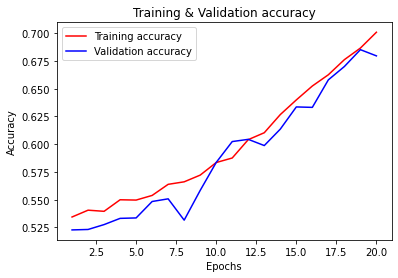

In [31]:
plot_accuracy(history1)

In [32]:
# Plotting the model loss
def plot_loss(history):
  training_loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(training_loss) + 1)
  plt.plot(epochs, training_loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training & Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

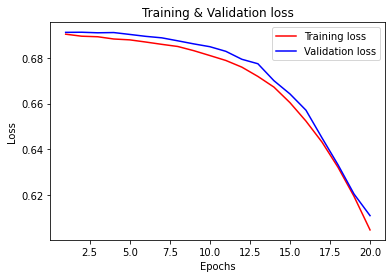

In [33]:
plot_loss(history1)

**Testing the model**

Testing the constructed MLP on the test data.

In [34]:
# Testing the model
scores = model1.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

782/782 [==============================] - 8s 10ms/step - loss: 0.6144 - accuracy: 0.6753
Accuracy: 67.53%


**Results of MLP #1**

This model gives only a 67.53% accuracy and is therefore not particularly good at predicting the sentiment. The validation loss and validation accuracy follows the loss and accuracy of the trained model, which is a good sign and shows that the model is not overfitting. However, early stopping is not applied and the model continues to improve as the number of epochs increases. A larger number of epochs could therefore result in a better model.

**MLP #2: using Adam**

Since the previous MLP only gave a 67% accuracy, we will now try to change the optimizer to Adam instead of stochastic gradient descent in hope of increasing the accuracy. Adam is generally known to converge faster whereas SGD generalizes better. When only using 20 epochs adam could therefore give a better performance.

In [35]:
model5 = Sequential()
model5.add(embedded_layer) # Adds embedded layer
model5.add(Flatten())
model5.add(Dense(units=250,
                 use_bias = True,
                 activation="relu"))
model5.add(Dropout(0.5))
model5.add(Dense(1,  
                 activation="sigmoid"))
model5.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           2834688   
                                                                 
 flatten_1 (Flatten)         (None, 16000)             0         
                                                                 
 dense_2 (Dense)             (None, 250)               4000250   
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 6,835,189
Trainable params: 6,835,189
Non-trainable params: 0
_________________________________________________________________


In [36]:
# To prevent overfitting
es = EarlyStopping(monitor='val_accuracy', 
                   patience=3)

# To tune the learning rate
rlronp = ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1, 
                          patience=3)

# To save the best model observed during training
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)


# Final model
history5 = model5.fit(x_train, 
                      y_train, 
                      validation_split=0.1, 
                      batch_size=64,
                      epochs=20, 
                      callbacks=[es, rlronp, mc])

Epoch 1/20
352/352 [==============================] - 32s 88ms/step - loss: 0.4045 - accuracy: 0.8072 - val_loss: 0.2880 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 2/20
352/352 [==============================] - 31s 87ms/step - loss: 0.1074 - accuracy: 0.9632 - val_loss: 0.3179 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 3/20
352/352 [==============================] - 31s 87ms/step - loss: 0.0143 - accuracy: 0.9963 - val_loss: 0.4340 - val_accuracy: 0.8764 - lr: 0.0010
Epoch 4/20
352/352 [==============================] - 31s 87ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.4960 - val_accuracy: 0.8728 - lr: 0.0010


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


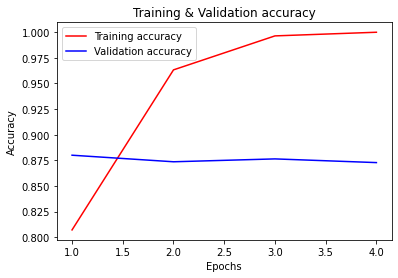

In [37]:
plot_accuracy(history5) 

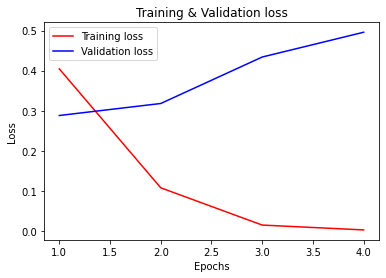

In [38]:
plot_loss(history5)

In [39]:
scores = model5.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

782/782 [==============================] - 8s 10ms/step - loss: 0.4936 - accuracy: 0.8686
Accuracy: 86.86%


**Results of MLP #2**

This model converges very fast and stops only after 4 epochs. The accuracy and loss graphs also show that model overfits the data since the validation loss increases when the training loss decreases. Still, this model gives a much better accuracy than the MLP #1 and is therefore better at predicting sentiment.

# Convolutional Neural Network (CNN)

**Constructing the model**

This CNN contains a 1-dimensional convolutional layers, a max-pooling layer and then the fully connected layer.

In [40]:
# Builds a sequential CNN-model by adding one layer at a time
model2 = Sequential()
model2.add(embedded_layer)
model2.add(Conv1D(filters = 128, 
                  kernel_size = 3, 
                  strides = 1,
                  padding = 'valid',
                  use_bias = True,
                  activation = 'relu')) # Relu is common in CNN
model2.add(MaxPooling1D())
model2.add(Flatten()) 
model2.add(Dense(units=250, 
                 activation='relu',
                 use_bias = True)) 
model2.add(Dropout(0.5))
model2.add(Dense(units=1, 
                 activation='sigmoid'))
model2.compile(loss='binary_crossentropy', 
               optimizer='sgd', 
               metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           2834688   
                                                                 
 conv1d (Conv1D)             (None, 498, 128)          12416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 249, 128)         0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 31872)             0         
                                                                 
 dense_4 (Dense)             (None, 250)               7968250   
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                      

In [41]:
# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_accuracy', patience=3)

# To tune the learning rate
rlronp = ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1, 
                          patience=3)

# To save the best model observed during training
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Final model
history2 = model2.fit(x_train, 
                      y_train, 
                      validation_split=0.1, 
                      batch_size=64,
                      epochs=20, 
                      callbacks=[es, rlronp, mc])

Epoch 1/20
352/352 [==============================] - 67s 189ms/step - loss: 0.6658 - accuracy: 0.7440 - val_loss: 0.6322 - val_accuracy: 0.8344 - lr: 0.0100
Epoch 2/20
352/352 [==============================] - 66s 188ms/step - loss: 0.5301 - accuracy: 0.8881 - val_loss: 0.4528 - val_accuracy: 0.8696 - lr: 0.0100
Epoch 3/20
352/352 [==============================] - 66s 187ms/step - loss: 0.3274 - accuracy: 0.9119 - val_loss: 0.3243 - val_accuracy: 0.8732 - lr: 0.0100
Epoch 4/20
352/352 [==============================] - 65s 185ms/step - loss: 0.2213 - accuracy: 0.9285 - val_loss: 0.2959 - val_accuracy: 0.8712 - lr: 0.0100
Epoch 5/20
352/352 [==============================] - 66s 187ms/step - loss: 0.1642 - accuracy: 0.9472 - val_loss: 0.3259 - val_accuracy: 0.8568 - lr: 0.0100
Epoch 6/20
352/352 [==============================] - 66s 188ms/step - loss: 0.1392 - accuracy: 0.9536 - val_loss: 0.3164 - val_accuracy: 0.8680 - lr: 0.0100


**Plotting the result**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


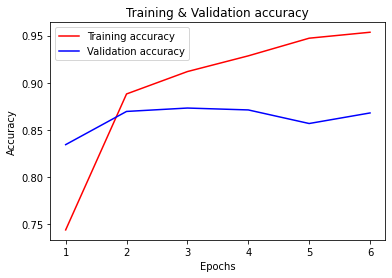

In [42]:
plot_accuracy(history2)

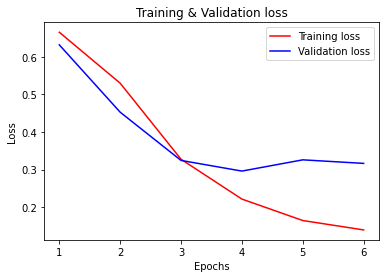

In [43]:
plot_loss(history2)

**Testing the model**

In [44]:
# Testing the model
scores = model2.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

782/782 [==============================] - 22s 28ms/step - loss: 0.3448 - accuracy: 0.8511
Accuracy: 85.11%


**Results of CNN #1**

The validation accuracy and validation loss follows the same shape as the accuracy and validation, and as with the MLP #1 it means it is not overfitting the data. With an accuracy of 85% after only 6 epochs it is a fairly good model. 

**CNN #2: using Adam**

The optimizer is now changed to Adam to see if the difference is as evident as it was with the MLP.

In [45]:
model4 = Sequential()
model4.add(embedded_layer)
model4.add(Conv1D(filters = 128, # Convolutial layer
                  kernel_size = 3, 
                  strides = 1,
                  use_bias = True,
                  padding = 'valid', 
                  activation = 'relu')) # Relu is common in CNN
model4.add(MaxPooling1D())
model4.add(Flatten()) # This must be done to get the correct shape of the output
model4.add(Dense(units=250, # Hidden layer of 250 units
                 activation='relu')) 
model4.add(Dropout(0.5))
model4.add(Dense(units=1, # Output layer
                 activation='sigmoid'))
model4.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           2834688   
                                                                 
 conv1d_1 (Conv1D)           (None, 498, 128)          12416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 249, 128)         0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 31872)             0         
                                                                 
 dense_6 (Dense)             (None, 250)               7968250   
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                      

In [46]:
# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_accuracy', patience=3)

# To tune the learning rate
rlronp = ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1, 
                          patience=3)

# To save the best model observed during training
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Final model
history4 = model4.fit(x_train, 
                      y_train, 
                      validation_split=0.1, 
                      batch_size=64,
                      epochs=20, 
                      callbacks=[es, rlronp, mc])

Epoch 1/20
352/352 [==============================] - 79s 222ms/step - loss: 0.1365 - accuracy: 0.9494 - val_loss: 0.3575 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 2/20
352/352 [==============================] - 78s 222ms/step - loss: 0.0291 - accuracy: 0.9900 - val_loss: 0.4605 - val_accuracy: 0.8916 - lr: 0.0010
Epoch 3/20
352/352 [==============================] - 78s 222ms/step - loss: 0.0110 - accuracy: 0.9963 - val_loss: 0.5808 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 4/20
352/352 [==============================] - 78s 222ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.7106 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 5/20
352/352 [==============================] - 78s 221ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.7244 - val_accuracy: 0.8864 - lr: 1.0000e-04


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


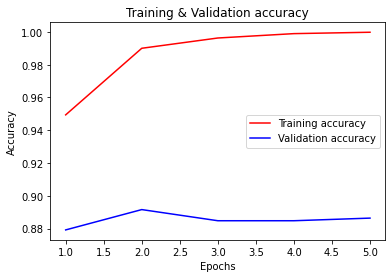

In [47]:
plot_accuracy(history4)

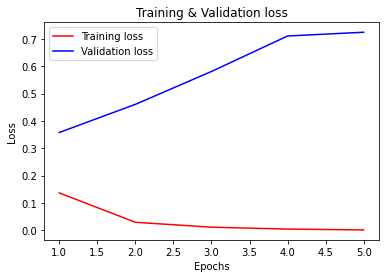

In [48]:
plot_loss(history4)

In [49]:
scores = model4.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

782/782 [==============================] - 22s 28ms/step - loss: 0.7938 - accuracy: 0.8598
Accuracy: 85.98%


**Results of CNN #2**

The first graph shows that as the number of epochs increases, the training accuracy increases and the validation accuracy stays constant. The second graph shows that training loss increases and the validation loss decreases as the number of epochs increase. This is a sign of overfitting. However, using Adam as optimizer gives approximately the same results as using stochastic gradient descent.

# Long Short-Term Memory (LSTM)

**Constructing the model**

This model is an LSTM, which is an improved version of a normal RNN. 

In [50]:
# Constructing the model
model3 = Sequential()
model3.add(embedded_layer)
model3.add(LSTM(units=128, 
                activation = "tanh", 
                recurrent_activation = "sigmoid",
                use_bias = True))
model3.add(Dense(units = 250,
                 use_bias = True,
                activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(units = 1, 
                activation = 'sigmoid'))
model3.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])
model3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           2834688   
                                                                 
 lstm (LSTM)                 (None, 128)               82432     
                                                                 
 dense_8 (Dense)             (None, 250)               32250     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 251       
                                                                 
Total params: 2,949,621
Trainable params: 2,949,621
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_acc', patience=3)

# To tune the learning rate
rlronp = ReduceLROnPlateau(monitor='val_loss',
                          factor=0.1, 
                          patience=3)

# To save the best model observed during training
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# Final model
history3 = model3.fit(x_train, 
                      y_train, 
                      batch_size=64,
                      validation_split=0.1, 
                      epochs=20, 
                      callbacks=[es, rlronp, mc])

Epoch 1/20
352/352 [==============================] - 359s 1s/step - loss: 0.1820 - acc: 0.9316 - val_loss: 0.4025 - val_acc: 0.8652 - lr: 0.0010
Epoch 2/20
352/352 [==============================] - 356s 1s/step - loss: 0.0532 - acc: 0.9819 - val_loss: 0.4598 - val_acc: 0.8744 - lr: 0.0010
Epoch 3/20
352/352 [==============================] - 351s 998ms/step - loss: 0.0233 - acc: 0.9920 - val_loss: 0.9296 - val_acc: 0.8480 - lr: 0.0010
Epoch 4/20
352/352 [==============================] - 346s 983ms/step - loss: 0.0236 - acc: 0.9920 - val_loss: 0.6751 - val_acc: 0.8772 - lr: 0.0010
Epoch 5/20
352/352 [==============================] - 343s 975ms/step - loss: 0.0047 - acc: 0.9987 - val_loss: 0.6108 - val_acc: 0.8728 - lr: 1.0000e-04
Epoch 6/20
352/352 [==============================] - 342s 972ms/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.6801 - val_acc: 0.8748 - lr: 1.0000e-04
Epoch 7/20
352/352 [==============================] - 343s 974ms/step - loss: 0.0014 - acc: 0.9998 - val

**Plotting the result**


dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


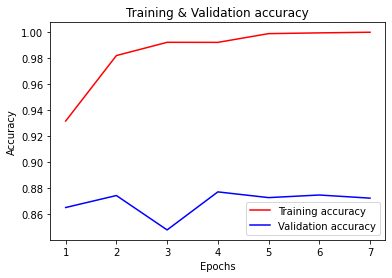

In [54]:
# Function for plotting the model accuracy because the dict keys are named differently in the LSTM history
def plot_accuracy(history):
  print(history.history.keys())
  training_acc = history.history['acc']
  val_acc = history.history['val_acc']
  epochs = range(1, len(training_acc) + 1)
  plt.plot(epochs, training_acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training & Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

plot_accuracy(history3)

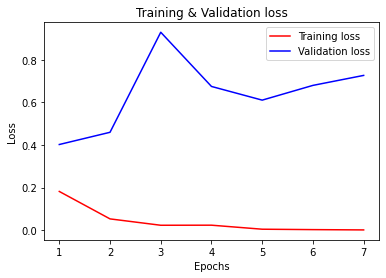

In [53]:
plot_loss(history3)

**Testing the model**

In [55]:
# Testing the model on the test set
scores = model3.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

782/782 [==============================] - 110s 141ms/step - loss: 0.8688 - acc: 0.8440
Accuracy: 84.40%


In [56]:
print("Best Validation Accuracy =", max(history3.history['val_acc'])*100)
print("Best Training Accuracy   =", max(history3.history['acc'])*100)

Best Validation Accuracy = 87.72000074386597
Best Training Accuracy   = 99.97777938842773


**Results of LSTM**

The LSTM gives a very high training accuracy, while the testing accuracy is almost the same as the CNN. Early stopping is also applied here after 7 epochs since the validation accuracy is not improving. 

# Using the models: tweets

In [58]:
# Function to predict the sentiment of an input string 
def predict_sentiment(sentence, model):
  word_to_index = imdb.get_word_index()
  split_sentence = [word.lower() for word in sentence.split()]
  text_indices = [word_to_index[word]+3 for word in split_sentence if word in word_to_index.keys()]
  model_input = [text_indices]
  model_input = sequence.pad_sequences(model_input, maxlen=500)
  prediction = model.predict(model_input)
  print(prediction)
  if (prediction>0.5):
      print("Prediction: Positive")
  else:
      print("Prediction: Negative")

By testing the models on clearly negative and positive tweets, we can see how they work in practice. Here the models are tested on two clearly angry tweets by Donald Trump and two happy tweets by Lin Manuel Miranda.

In [70]:
# Donald J. Trump (@realDonaldTrump) March 22, 2018
tweet1 = "Crazy Joe Biden is trying to act like a tough guy. Actually, he is weak, both mentally and physically, and yet he threatens me, for the second time, with physical assault. He doesn’t know me, but he would go down fast and hard, crying all the way. Don’t threaten people Joe!"
# Donald J. Trump (@realDonaldTrump) July 23, 2018
tweet2 = "To Iranian President Rouhani: NEVER, EVER THREATEN THE UNITED STATES AGAIN OR YOU WILL SUFFER CONSEQUENCES THE LIKES OF WHICH FEW THROUGHOUT HISTORY HAVE EVER SUFFERED BEFORE. WE ARE NO LONGER A COUNTRY THAT WILL STAND FOR YOUR DEMENTED WORDS OF VIOLENCE & DEATH. BE CAUTIOUS!"

# Lin Manuel Miranda (@Lin_Manuel) April 29, 2016
tweet3 = "Good morning. You are perfectly cast in your life. I can't imagine anyone but you in the role. Go play."
# Lin Manuel Miranda (@Lin_Manuel) January 3, 2018
tweet4 = "Find words for all your daily joys & terrors. Gnight; make work that gets us in our feelings. Send off to bed your doubt, your shame, your errors. Break curfew with your muses, shatter ceilings. The year is fresh; wipe clean inertia’s mildew. Grateful for all you do, & all you will do"

**MLP**

In [71]:
# MLP #1
predict_sentiment(tweet1, model1)
predict_sentiment(tweet2, model1)
predict_sentiment(tweet3, model1)
predict_sentiment(tweet4, model1)

[[0.47617924]]
Prediction: Negative
[[0.5409452]]
Prediction: Positive
[[0.5215847]]
Prediction: Positive
[[0.5079296]]
Prediction: Positive


In [72]:
# MLP #2
predict_sentiment(tweet1, model5)
predict_sentiment(tweet2, model5)
predict_sentiment(tweet3, model5)
predict_sentiment(tweet4, model5)

[[0.0572859]]
Prediction: Negative
[[0.33587134]]
Prediction: Negative
[[0.7014046]]
Prediction: Positive
[[0.7435388]]
Prediction: Positive


**CNN**

In [73]:
# CNN #1
predict_sentiment(tweet1, model2)
predict_sentiment(tweet2, model2)
predict_sentiment(tweet3, model2)
predict_sentiment(tweet4, model2)

[[0.38474938]]
Prediction: Negative
[[0.75988245]]
Prediction: Positive
[[0.6465994]]
Prediction: Positive
[[0.64980084]]
Prediction: Positive


In [74]:
# CNN #2
predict_sentiment(tweet1, model4)
predict_sentiment(tweet2, model4)
predict_sentiment(tweet3, model4)
predict_sentiment(tweet4, model4)

[[0.96331]]
Prediction: Positive
[[0.99990845]]
Prediction: Positive
[[0.99952805]]
Prediction: Positive
[[0.99969876]]
Prediction: Positive


**LSTM**

In [75]:
# LSTM
predict_sentiment(tweet1, model3)
predict_sentiment(tweet2, model3)
predict_sentiment(tweet3, model3)
predict_sentiment(tweet4, model3)

[[0.00074157]]
Prediction: Negative
[[0.15411651]]
Prediction: Negative
[[0.04180038]]
Prediction: Negative
[[0.00214818]]
Prediction: Negative


Only using 4 examples does not give very representative data and we see that the results when trying to classify these vary a lot across the models. Still, it is interesting to see how the models work when classifying these, and that they provide very different numbers when predicting the sentiment. We see that the MLP #2 predicts all 4 tweets correctly and CNN #1 and MLP #1 predict 3/4 correctly. CNN #2 and LSTM predicts only 2/4 correctly, which is a bit surprising.

To generalize better a larger test set of tweets is needed, perhaps also with a clearer sentiment. 

# Conclusion
The results from the testing set shows that CNN and LSTM gives approximately the same accuracy. Seen as CNN is more widely used in image classification while LSTM is more used in natural language processing, this result is a bit surprising. However, an accuracy of 85% shows that it is fully possible to use CNN for sentiment analysis. 

Another suprising result was the large difference in accuracy on the MLP when changing the optimization algorithm. Stochastic gradient descent was not very efficient when only using 20 epochs, most likely because it converges very slow. Increasing the number of epochs could be a solution, but a faster way to solve this problem was changing the optimization algorithm to adam. The model now converged after only 4 epochs and at the same time achieving an accuracy of 86.9%. This is approx. the same as the LSTM and CNN, actually a tiny bit above, and it is a much simpler model.

In the Stanford paper from 2011, the researchers achieved an accuracy of 88.89% when using the IMDB dataset. Comparing it with the findings from this project, the results are almost the same. However, in later competitions (2014) the participants managed to get a 97-99% accuracy on the same datset. Still, the results of 85-87% shows that the models in most cases manages to predict sentiment correctly, and that the simpler models can be as good as the more time-consuming and complicated ones. 

# References 

*   Powerpoints from lectures about deep learning
*   https://keras.io/api/
*   https://keras.io/api/datasets/imdb/
*   https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/
*   https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
*   https://machinelearningmastery.com/what-are-word-embeddings/
*   https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
*   https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008
*   https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47
*   https://news.sky.com/story/us-election-donald-trumps-45-most-controversial-tweets-12098204
*   https://www.buzzfeed.com/vannessajackson/lin-manuel-miranda-inspirational-tweets



